## Cargamos los imports.

In [5]:
import init

In [3]:
import grafo as grafo
import experimento as exp
import modelo as modelo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

## Estudio de la propagación y dinámica de precios a partir de la Matriz de Insumo-Producto (MIP)

**Grupo**: 6

**Integrantes**: Miguel De Lillo, Manuel Fernandez, Augusto Kielbowicz, Mariano Oca 

[**Repositorio**](https://github.com/akielbowicz/tp-msscae-2024?tab=readme-ov-file#trabajo-pr%C3%A1ctico-de-msscae-2024)

# Motivación
La idea de este modelo es estudiar, ante un shock de precios en un sector dado, cómo afectan las dinámicas propuestas entre los sectores productivos de la Argentina en la inflación global calculada a partir de las variaciones en los precios de los mismos. (Utilizando las relaciones dadas por la matriz de Insumo-Producto). 


<!-- Ejemplo de los resultados del grafo de MIP y la curva de inflacion -->
TODO: Agregar imagenes acá
<!-- ![grafo](./grafo.png) -->

<!-- ![inflacion](./inflacion.png) -->

<!-- Indice/TOC -->
- [Introducción](#Introducción)
    - [Preguntas a responder](#Preguntas-a-responder)
    - [Suposiciones (y limitaciones) del modelo](#Suposiciones-(y-limitaciones)-del-modelo)
- A
- B
- C
- [Conclusiones](#Conclusiones)
- [Apéndices](#Apéndices)
    - [Código](#Código) 

# Introducción

## Preguntas a responder

- ¿Cómo se propaga el aumento de precios a través de la red definida por la MIP?

- ¿Cómo impacta el aumento de precio en un producto/sector sobre otros productos/sectores? ¿Se mantiene en la misma cadena productiva?

- ¿Qué métricas se pueden computar sobre todo el sistema para describir el estado global del sistema? 

- ¿Cómo influyen las dinámicas de comportamiento de los agentes en la variación de la inflación global?

- ¿Cuál es la sensibilidad del sistema respecto a variaciones de precio en nodos específicos? ¿Cuáles son los nodos que propagan de mayor forma la variación de precios?

## Suposiciones (y limitaciones) del modelo

- Cada agente es un sector productivo de la Argentina. Éste representaría a todos los productos (y productores) del sector.

- Un cambio de precios >0 en los insumos provoca un cambio de precios saliente del agente (producción). Sólo vamos a estudiar variaciones positivas en los precios para atenernos a las preguntas a investigar con el modelo.

- La economía es cerrada. Esto es, no se traen productos de otros países (importaciones) ni se vende nada a ellos (exportaciones) durante la evolución del sistema.

- Rige la Ley de Say: la oferta es igual a la demanda.

# Matriz Insumo Producto y Análisis

Acá mostramos un poco el análisis del grafo y lo visualizamos

In [3]:
mip = pd.read_csv('../resources/MIP_normalizada.csv', index_col=0)

In [4]:
mip

,"Cultivo de cereales, oleaginosas y forrajeras","Cultivo de hortalizas, legumbres, flores y plantas ornamentales",Cultivo de frutas y nueces,Cultivos industriales,Producción de semillas,"Cría de ganado y producción de leche, lana y pelos",Producción de granja,Servicios agropecuarios,Caza,Silvicultura y extracción de madera,...,Enseñanza pública,Enseñanza privada,Salud humana pública,Salud humana privada,Servicios veterinarios,Servicios sociales,Servicios de saneamiento,Actividad de asociaciones,"Servicios de cine, radio y televisión","Servicios personales, de reparación, actividades deportivas y de esparcimiento"
"Cultivo de cereales, oleaginosas y forrajeras",0.010319,0.000000,0.001542,0.001601,0.000000,0.181660,0.012263,0.000000,0.000000e+00,0.000000,...,0.000038,0.000080,0.000007,0.000042,0.000012,0.000000,0.000000,0.000000,1.735054e-09,0.003256
"Cultivo de hortalizas, legumbres, flores y plantas ornamentales",0.000000,0.167226,0.009565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.005679,0.012030,0.002192,0.008913,0.000000,0.001238,0.000000,0.007999,1.237709e-06,0.079292
Cultivo de frutas y nueces,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.003827,0.008099,0.011067,0.005904,0.000000,0.001638,0.000000,0.000000,1.472092e-07,0.000006
Cultivos industriales,0.000000,0.000000,0.000000,0.020212,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
Producción de semillas,0.783146,0.016374,0.029820,0.017254,0.021740,0.127875,0.002291,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Servicios sociales,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
Servicios de saneamiento,0.000870,0.000193,0.000127,0.000219,0.000107,0.000952,0.000202,0.000148,1.460399e-06,0.000078,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
Actividad de asociaciones,0.003092,0.000686,0.000453,0.000777,0.000379,0.003384,0.000985,0.000526,4.849340e-06,0.000276,...,0.000000,0.000000,0.000000,0.482561,0.005531,0.000000,0.000000,0.000000,3.831347e-03,0.000000
"Servicios de cine, radio y televisión",0.000536,0.000106,0.000069,0.000121,0.000055,0.000569,0.000564,0.000076,7.971898e-07,0.000423,...,0.001680,0.004810,0.000517,0.007592,0.000178,0.000856,0.001262,0.019357,8.850829e-02,0.017336


In [5]:
# Visualización del grafo en spring layout con centralidad de autovalores.
# La centralidad de autovalores mide la influencia de un nodo sobre la red basado en la influencia de sus vecinos.

In [6]:
# Visualización del grafo con todos los nodos distribuidos y legibles.

In [7]:
# Métricas del grafo. Distribución de grado de salida y de entrada. Coeficiente de clustering, etc. El output de esto deberían ser los nodos sobre los cuales vamos a hacer los experimentos y por qué. Eigenvector centrality.

# Los experimentos

In [4]:
def plot_inflaciones(inflaciones, aumento, umbral_label=0.5):
    fig, (ax,ax2) = plt.subplots(1,2,figsize=(22, 10))
    ax.set_title(f"Valor de la inflación en el tiempo, a partir de un shock de {aumento}% \n para todos los sectores.")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Porcentaje de inflación")
    ax2.set_title(f"Variación de la inflación en el tiempo, a partir de un shock de {aumento}%, \n para todos los sectores.")
    ax2.set_xlabel("Tiempo")
    ax2.set_ylabel("Porcentaje de inflación")
    for i, inflacion in enumerate(inflaciones):
        tiempo = range(0,len(inflacion))
        if (max(inflacion) > umbral_label):
            ax.plot(tiempo, inflacion, label=sectores[i])
            ax2.plot(tiempo[1:],np.diff(inflacion), label=sectores[i])
        else:
            ax.plot(tiempo, inflacion)
            ax2.plot(tiempo[1:],np.diff(inflacion))
    ax.legend()
    ax2.legend()
    plt.show()

Esqueleto de experimento:
- visualizacion del nodo desde donde se lanza el shock con su vecindario (dos niveles de separación como mucho?) ó de su clúster.
- codigo de shock de inflación 
- visualizacion de la inflacion en funcion de t 
- visualizacion de la variacion de la inflacion en funcion de t
- grafo total pintado por la inflacion.

## Experimentación con la dinámica 1. 

C:\Users\augus\AppData\Local\Temp\ipykernel_14720\2569110641.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
C:\Users\augus\AppData\Local\Temp\ipykernel_14720\2569110641.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


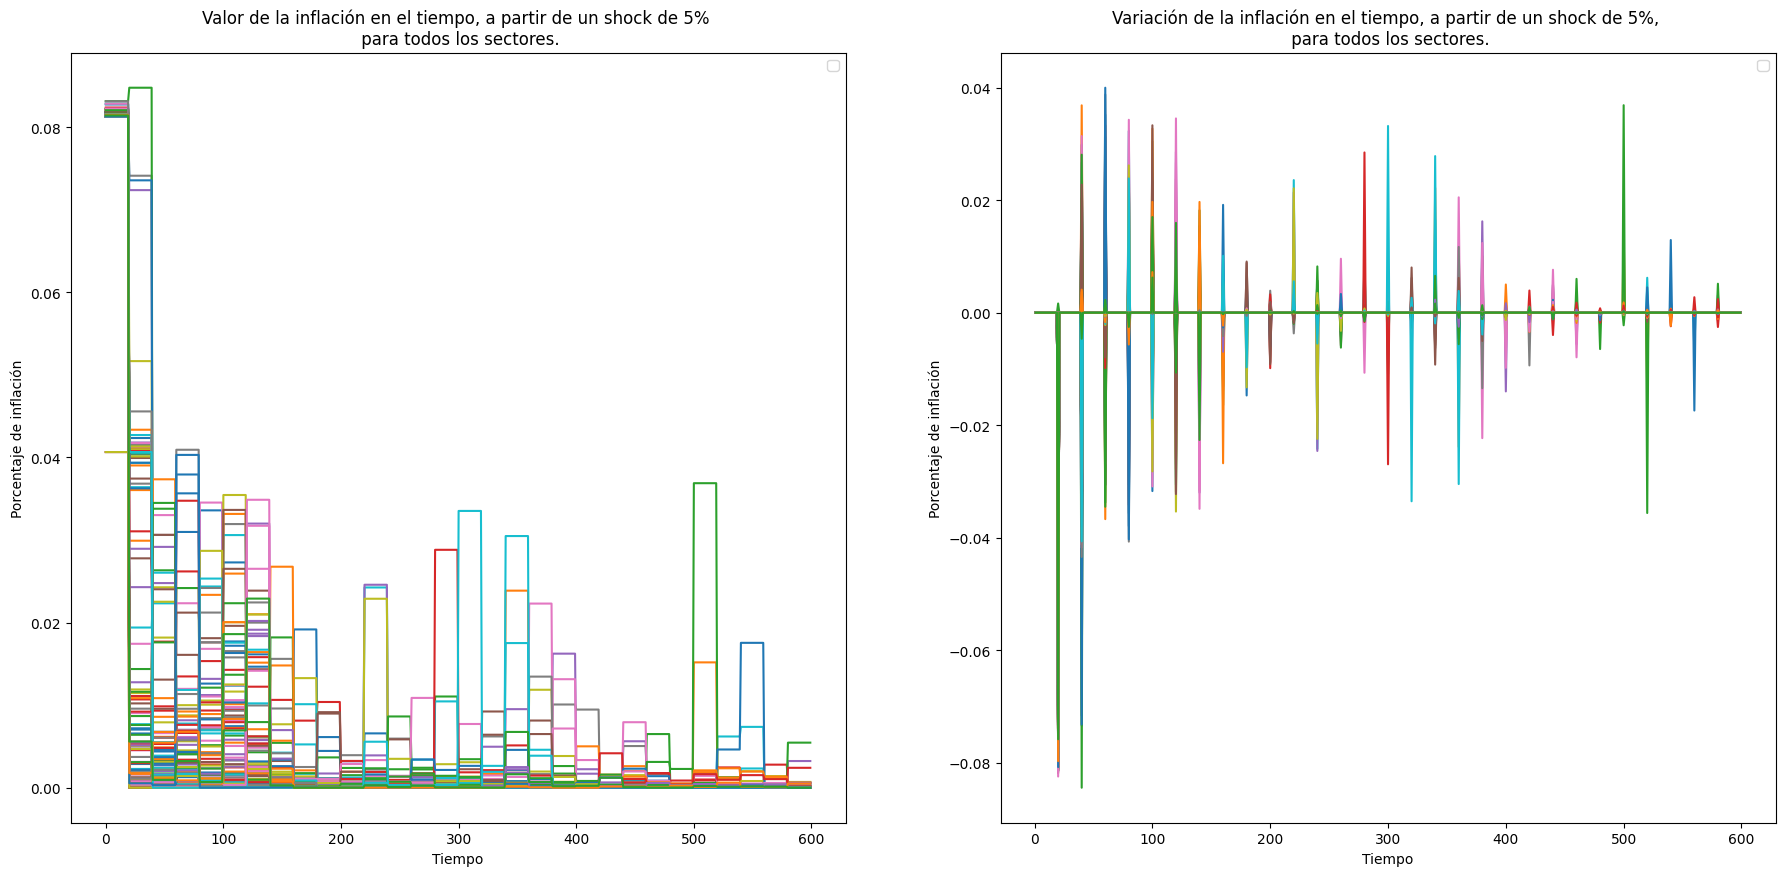

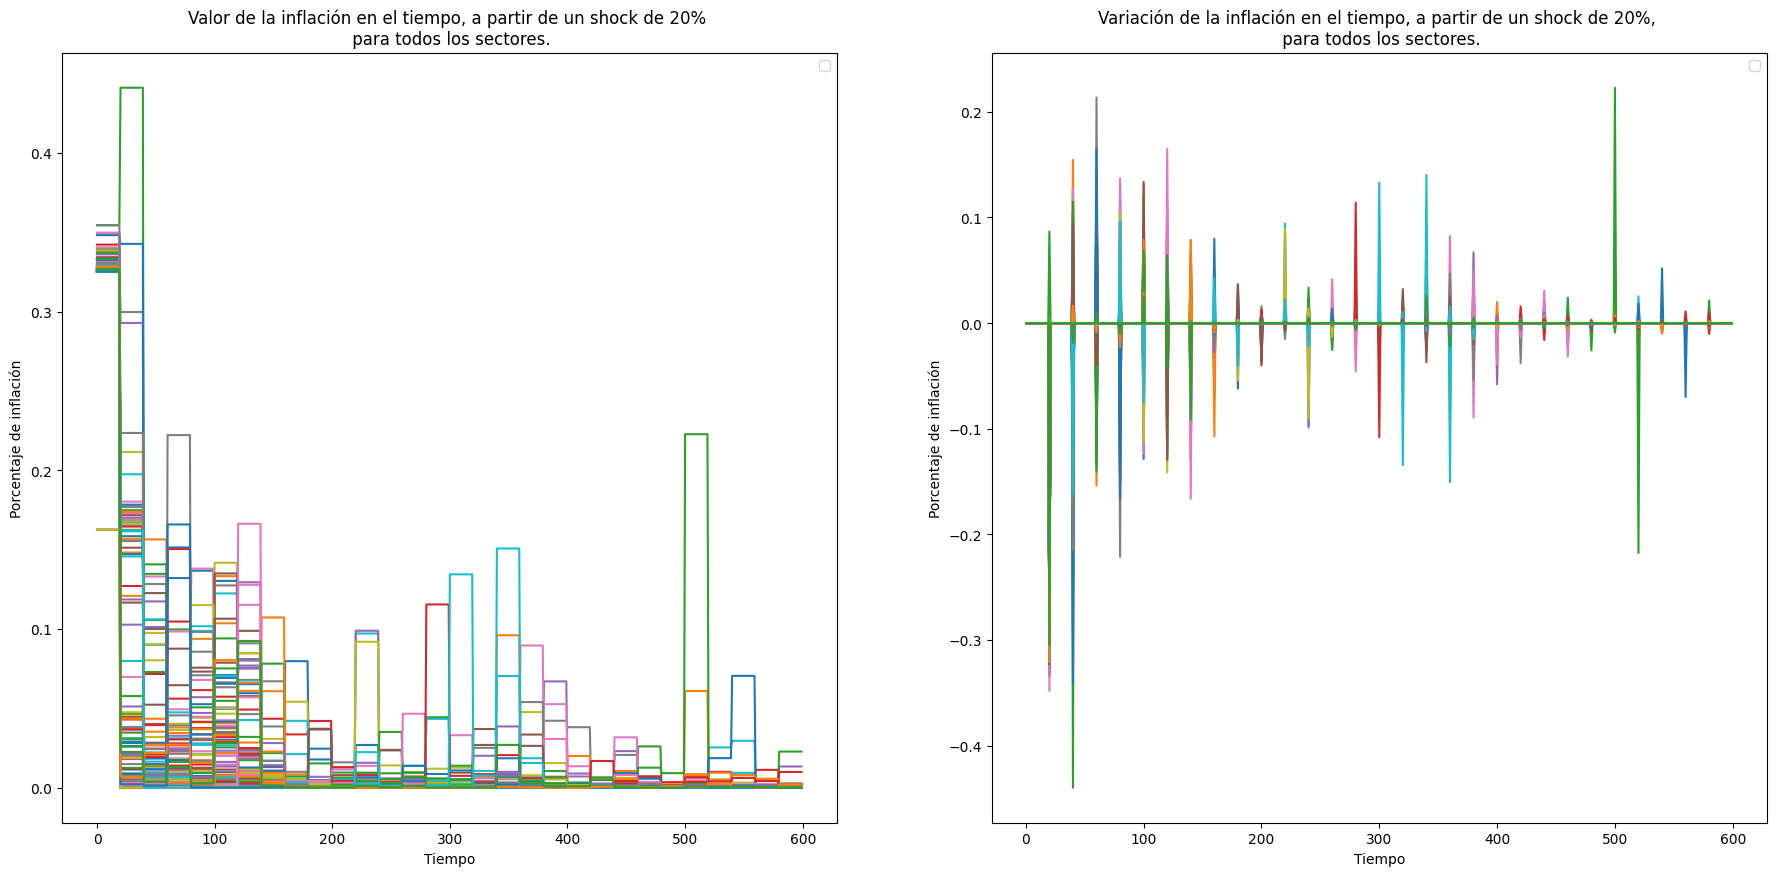

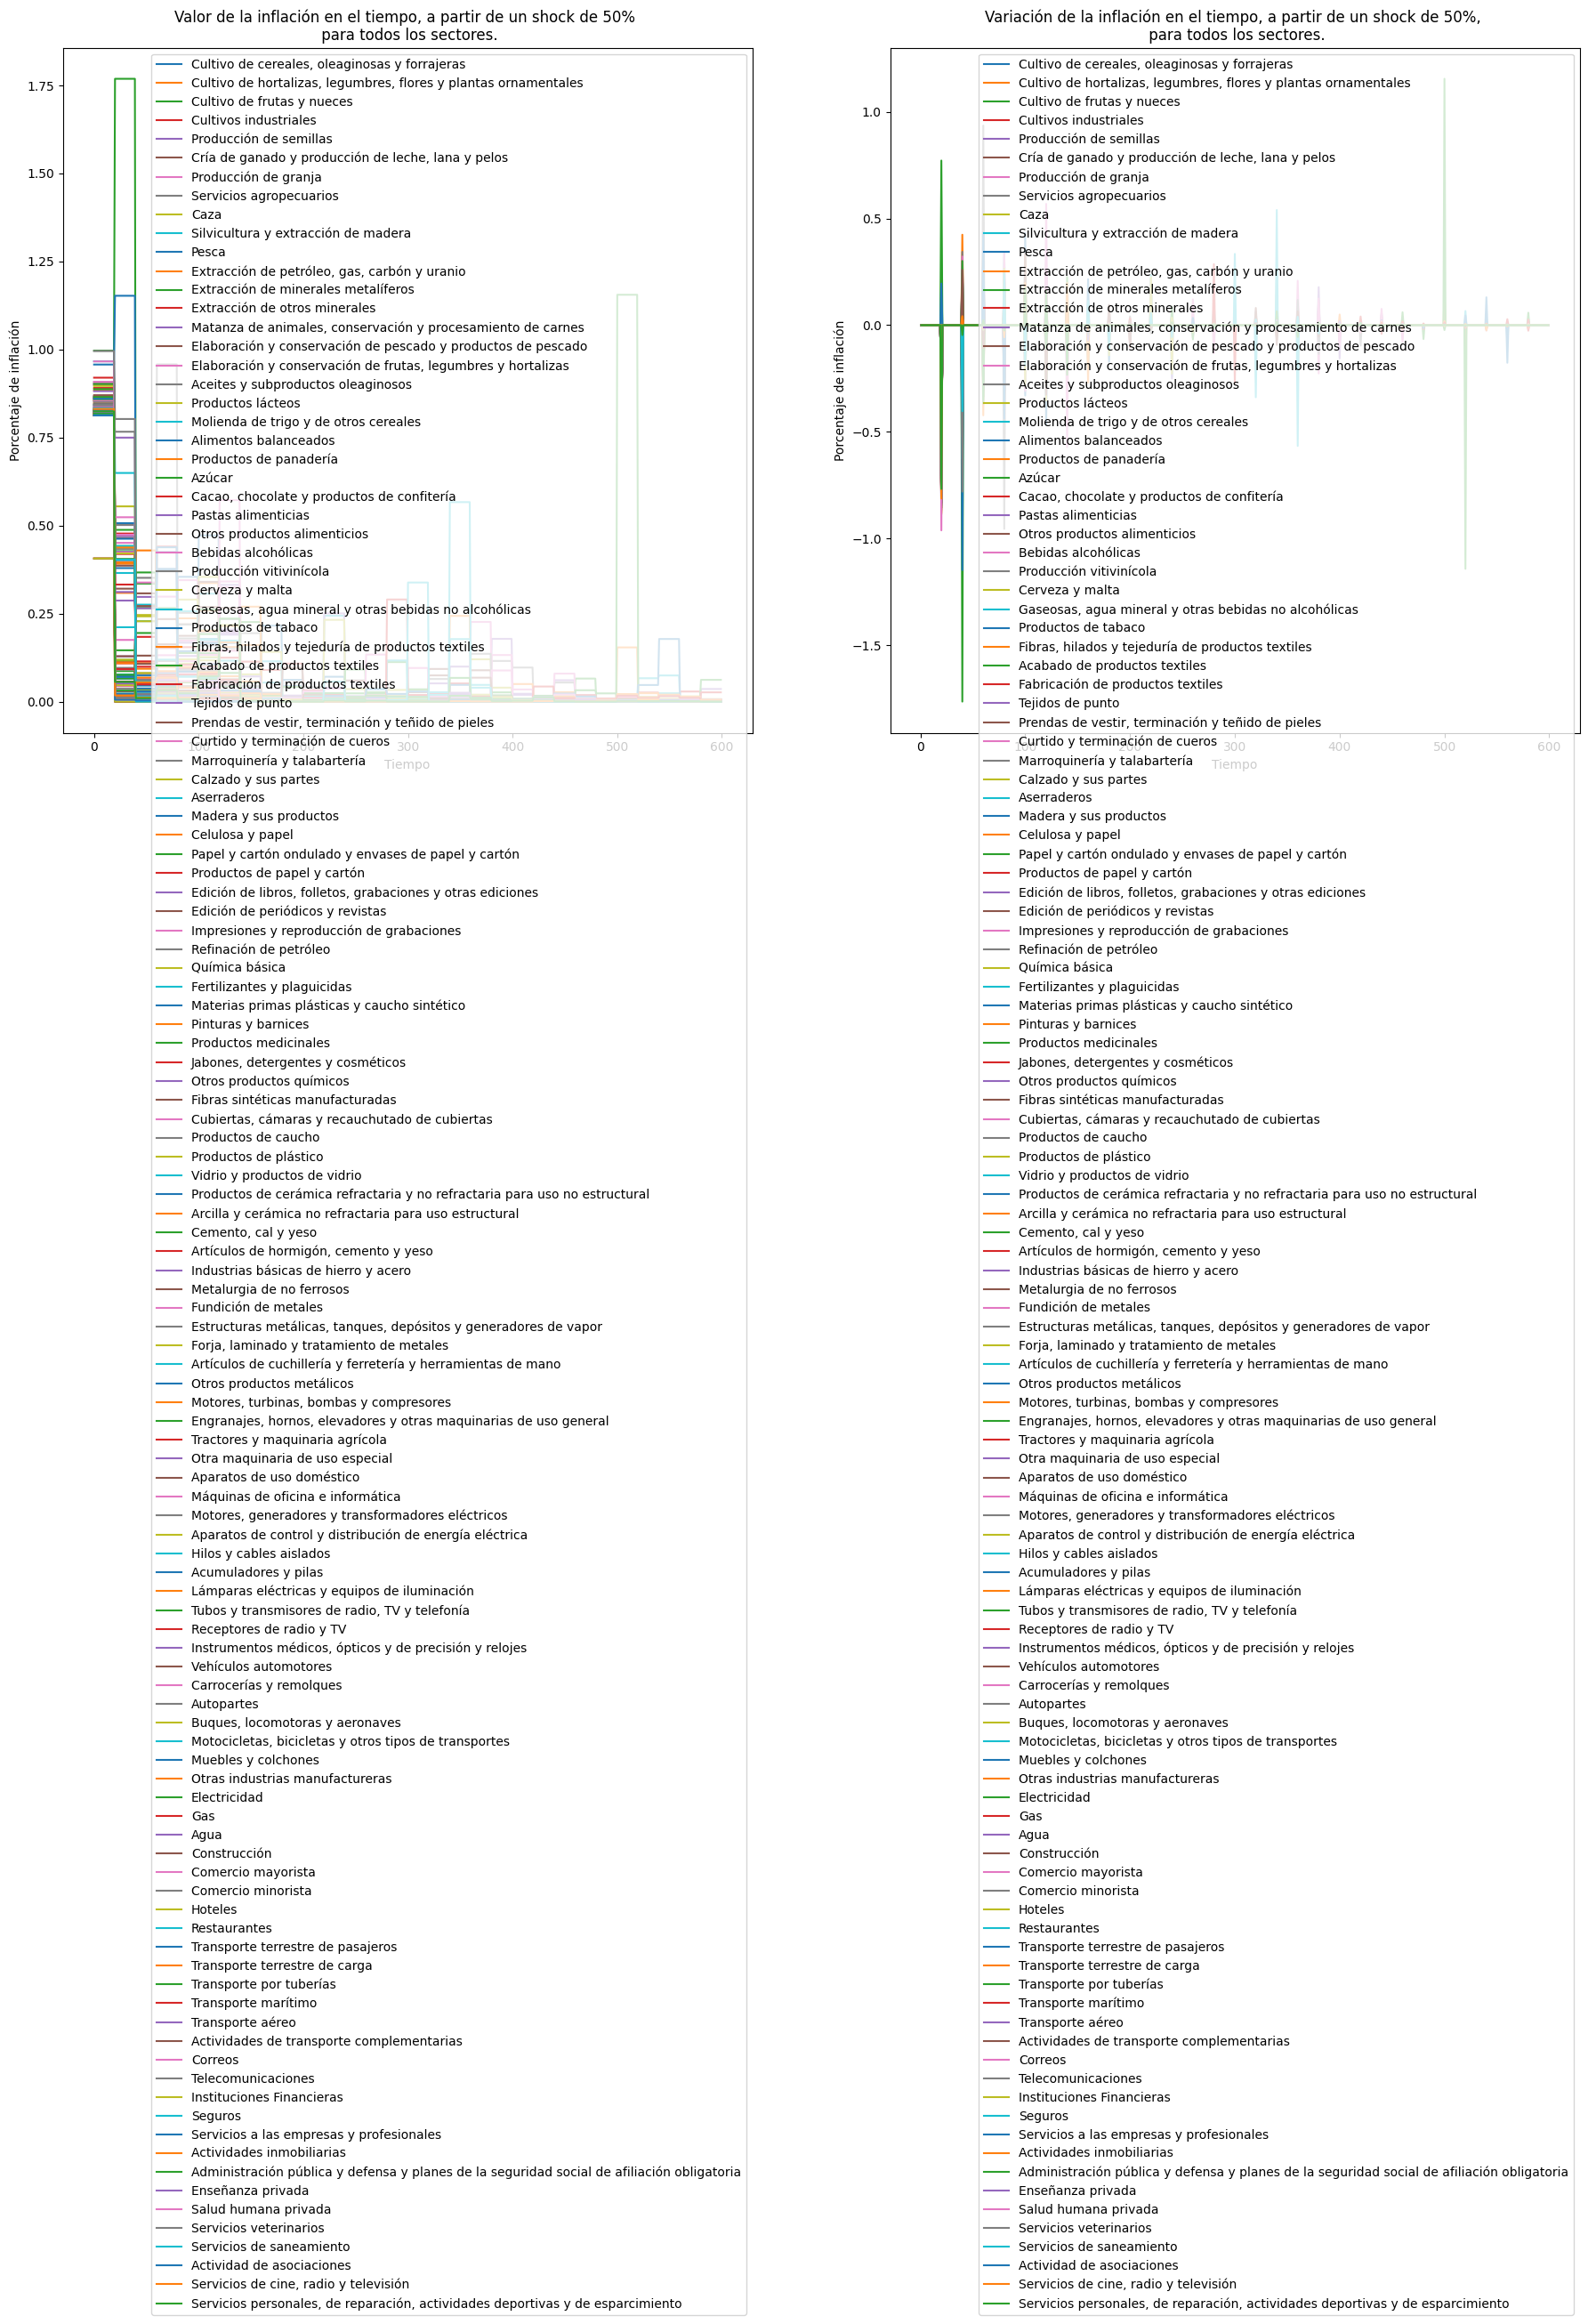

In [9]:
aumentos = [5,20,50]
for aumento in aumentos:
    mip_grafo = grafo.armar_grafo(mip,precios_random=False)
    sectores = list(mip_grafo.nodes)
    inflaciones = []
    for sector in sectores:
        experimento = exp.Experimento(mip_grafo,
                                dinamica=modelo.dinamica_1,
                                calcular_inflacion=modelo.calcular_inflacion,
                                duracion_periodo=20)
        experimento.shock(sector,aumento)
        experimento.step(600)
        inflacion = experimento.metricas_evaluadas['inflacion']
        inflaciones.append(inflacion)  
    plot_inflaciones(inflaciones,aumento)

# Experimentos con la dinámica 3.

### alpha = 0 (Igual que la dinámica 1)

C:\Users\augus\AppData\Local\Temp\ipykernel_14720\2569110641.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
C:\Users\augus\AppData\Local\Temp\ipykernel_14720\2569110641.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


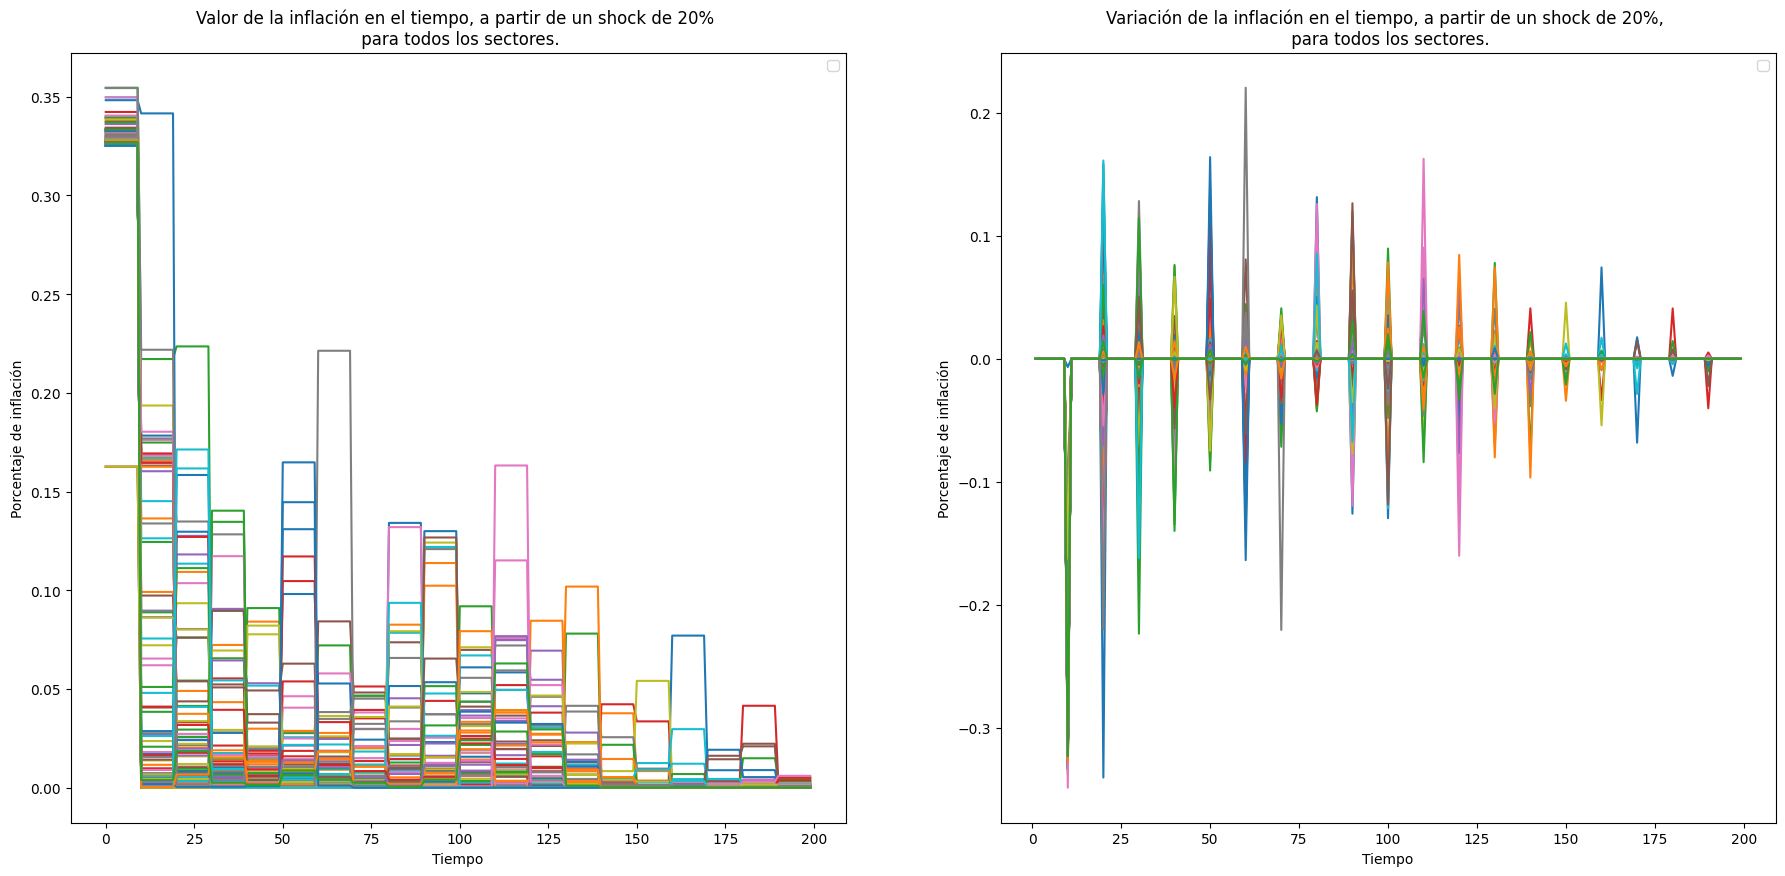

In [10]:
aumentos = [20]
alpha = 0
mip_grafo = grafo.armar_grafo(mip,precios_random=False)
sectores = list(mip_grafo.nodes)
for j, aumento in enumerate(aumentos):       
    inflaciones = []
    for sector in sectores:
        experimento = exp.Experimento(mip_grafo,
                                dinamica=modelo.dinamica_3,
                                calcular_inflacion=modelo.calcular_inflacion,
                                alpha=alpha)
        experimento.shock(sector,aumento)
        experimento.step(200)
        inflacion = experimento.metricas_evaluadas['inflacion']
        inflaciones.append(inflacion)  
    plot_inflaciones(inflaciones, aumento)

### Alpha = 0.2

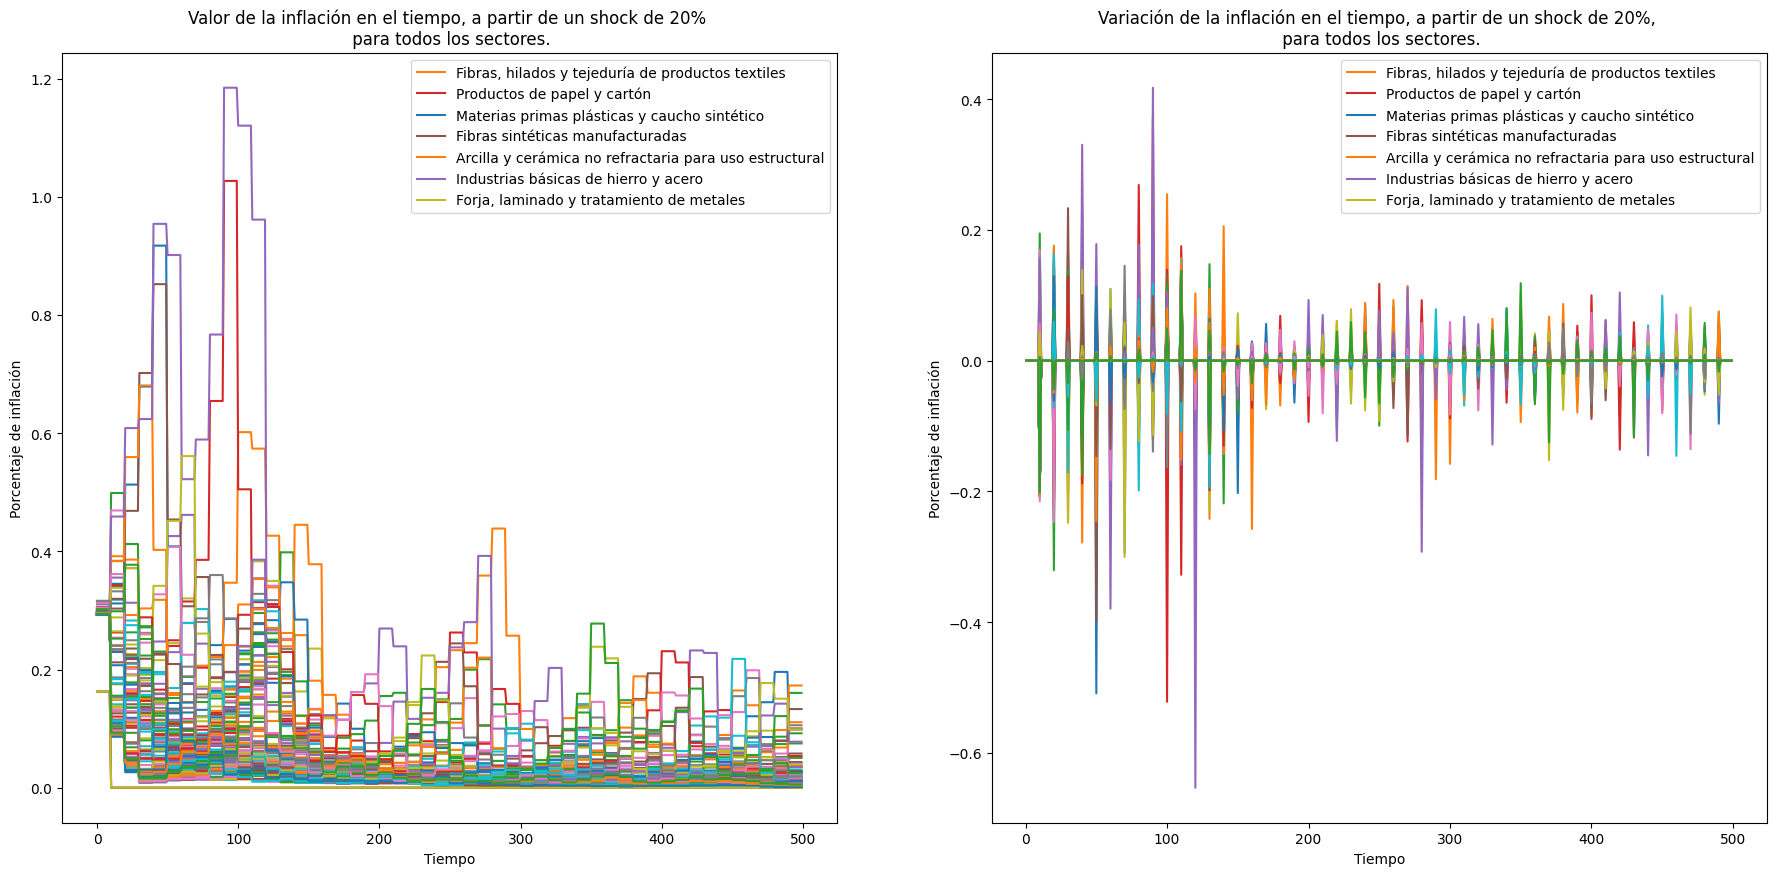

In [11]:
aumentos = [20]
umbral_visualizacion = [1000,2000,2000]
alpha = 0.2
mip_grafo = grafo.armar_grafo(mip,precios_random=False)
sectores = list(mip_grafo.nodes)
for j, aumento in enumerate(aumentos):       
    inflaciones = []
    for sector in sectores:
        experimento = exp.Experimento(mip_grafo,
                                dinamica=modelo.dinamica_3,
                                calcular_inflacion=modelo.calcular_inflacion,
                                alpha=alpha)
        experimento.shock(sector,aumento)
        experimento.step(500)
        inflacion = experimento.metricas_evaluadas['inflacion']
        inflaciones.append(inflacion)  

    plot_inflaciones(inflaciones,aumento,0.5)

### Alpha 0.3

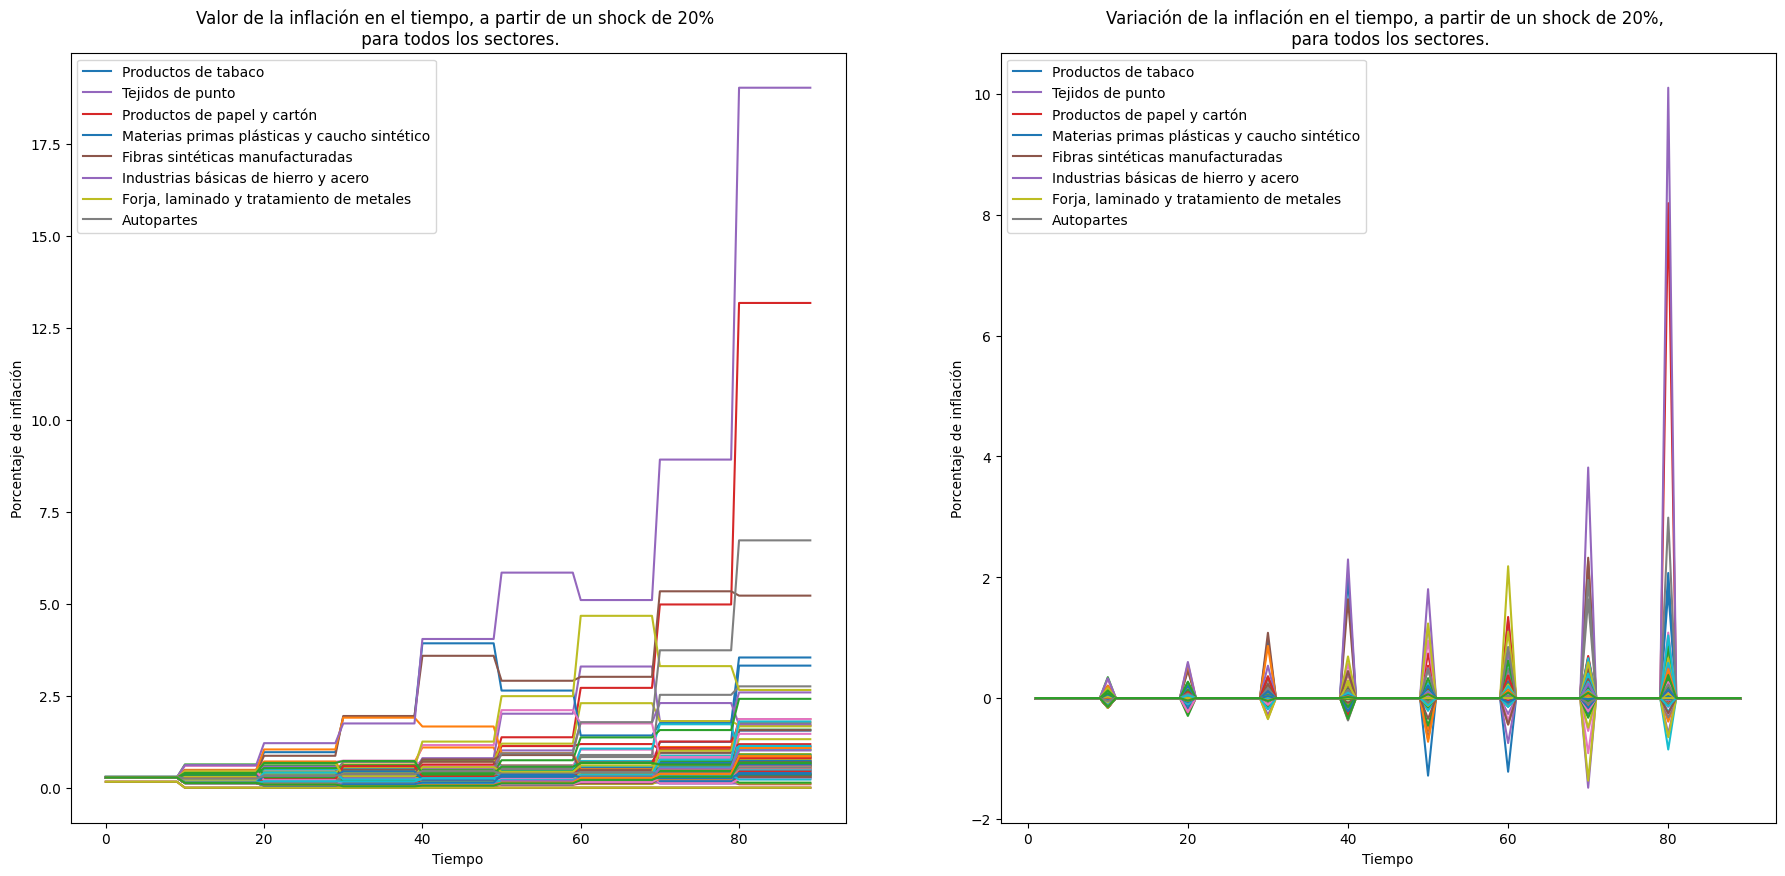

In [12]:
aumento = 20
# umbral_visualizacion = [1000]
alpha = 0.3
mip_grafo = grafo.armar_grafo(mip,precios_random=False)
sectores = list(mip_grafo.nodes)
inflaciones = []
for sector in sectores:
    experimento = exp.Experimento(mip_grafo,
                            dinamica=modelo.dinamica_3,
                            calcular_inflacion=modelo.calcular_inflacion,
                            alpha=alpha)
    experimento.shock(sector,aumento)
    experimento.step(90)
    inflacion = experimento.metricas_evaluadas['inflacion']
    inflaciones.append(inflacion)  
plot_inflaciones(inflaciones, aumento,3)

#### El mismo experimento pero con más pasos.

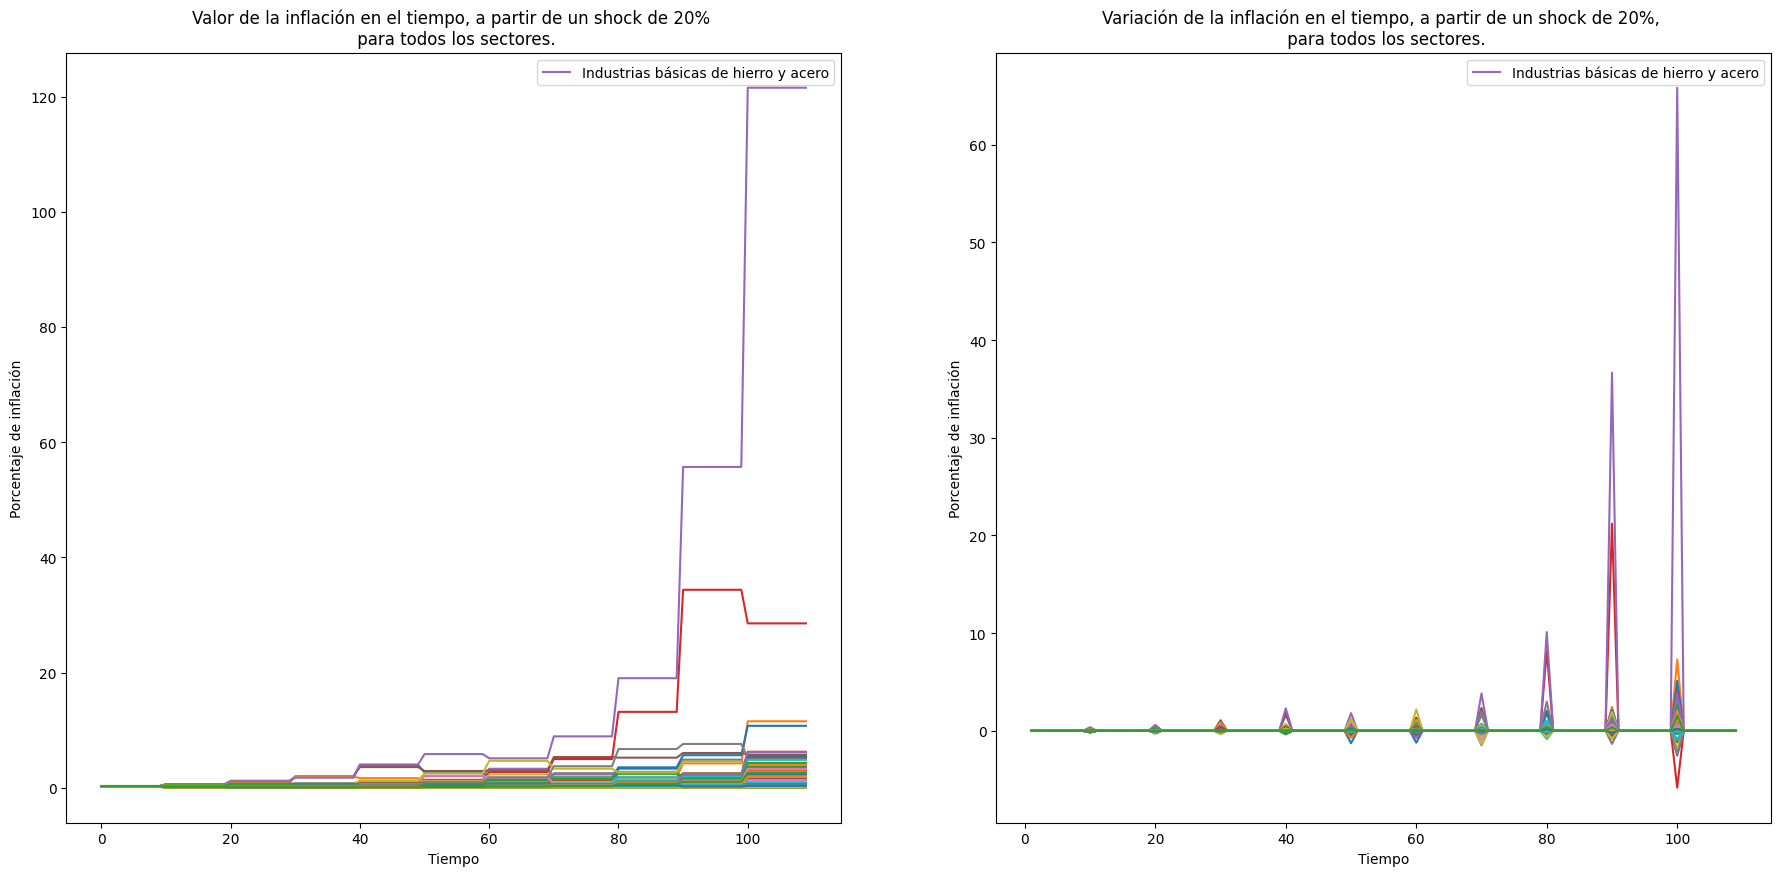

In [13]:
aumento = 20
# umbral_visualizacion = [1000]
alpha = 0.3
mip_grafo = grafo.armar_grafo(mip,precios_random=False)
sectores = list(mip_grafo.nodes)
inflaciones = []
for sector in sectores:
    experimento = exp.Experimento(mip_grafo,
                            dinamica=modelo.dinamica_3,
                            calcular_inflacion=modelo.calcular_inflacion,
                            alpha=alpha)
    experimento.shock(sector,aumento)
    experimento.step(110)
    inflacion = experimento.metricas_evaluadas['inflacion']
    inflaciones.append(inflacion)  
plot_inflaciones(inflaciones,aumento,100)

### Alpha 0.4

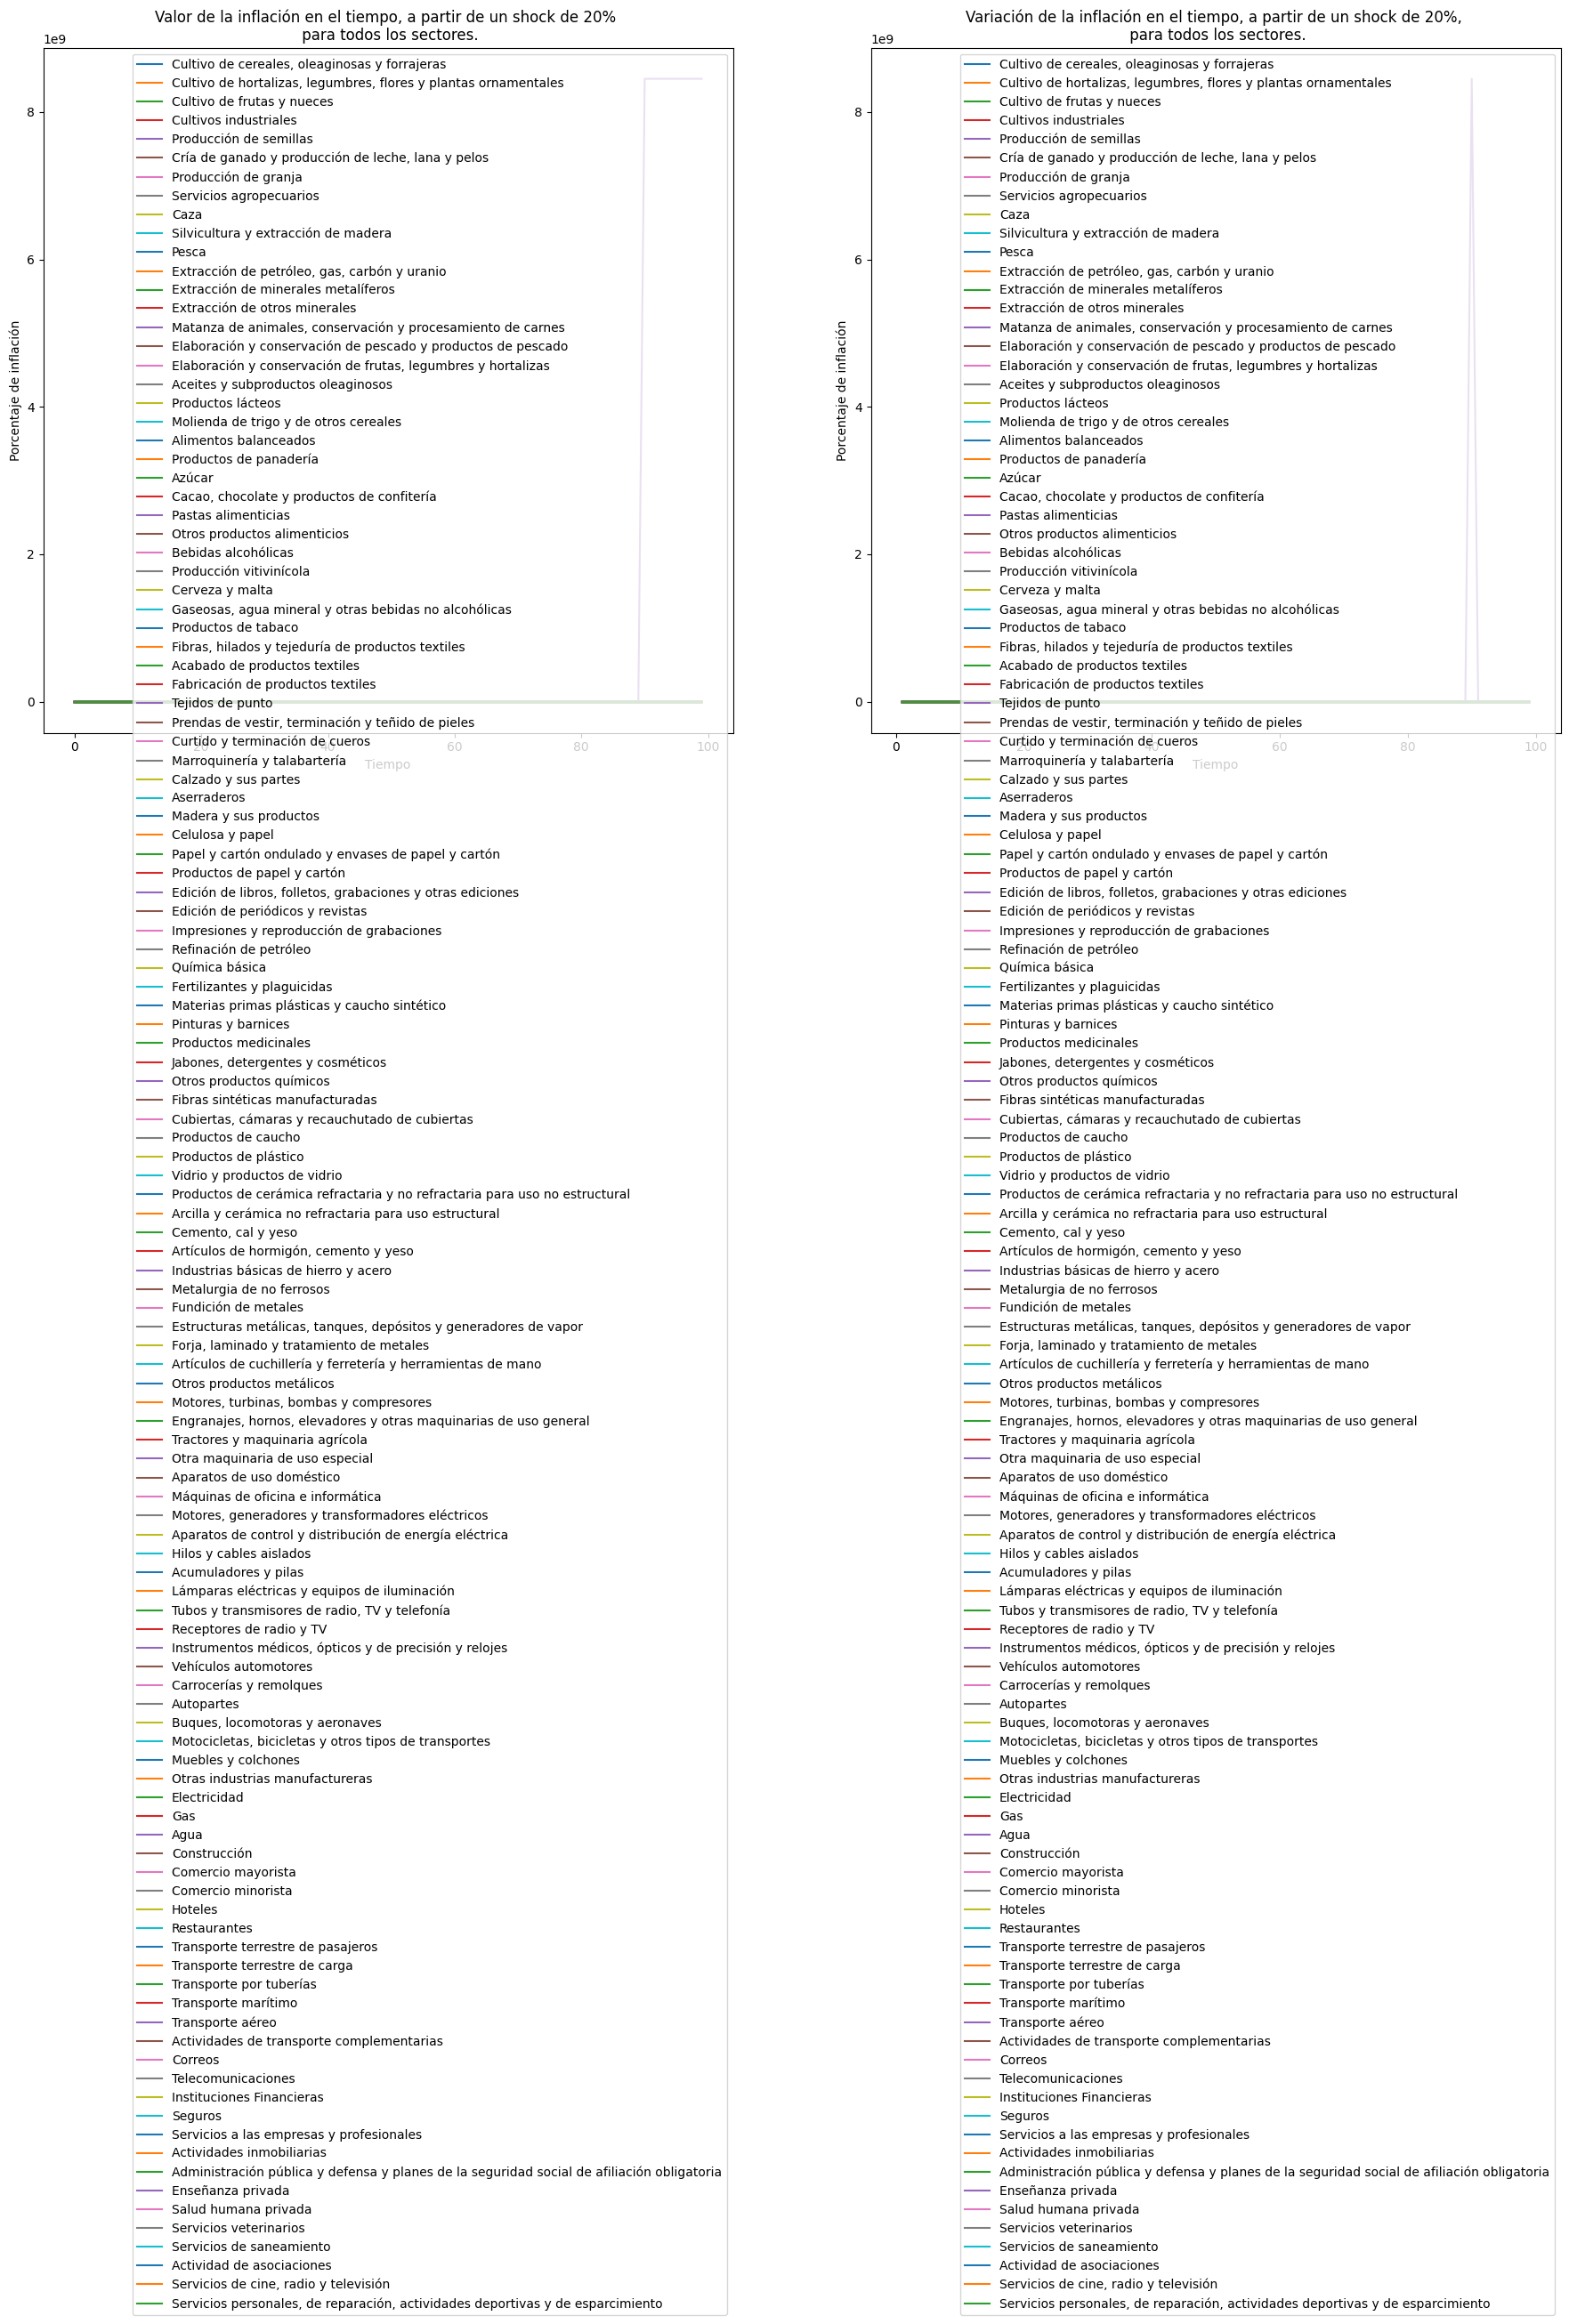

In [14]:
aumento = 20
# umbral_visualizacion = [1000]
alpha = 0.4
mip_grafo = grafo.armar_grafo(mip,precios_random=False)
sectores = list(mip_grafo.nodes)
inflaciones = []
for sector in sectores:
    experimento = exp.Experimento(mip_grafo,
                            dinamica=modelo.dinamica_3,
                            calcular_inflacion=modelo.calcular_inflacion,
                            alpha=alpha)
    experimento.shock(sector,aumento)
    experimento.step(100)
    inflacion = experimento.metricas_evaluadas['inflacion']
    inflaciones.append(inflacion)  
plot_inflaciones(inflaciones, aumento)

# Conclusiones

## Sobre los experimentos y las preguntas respondidas
 - Los nodos 112, 113 y 6 son los más influyentes en la red según la centralidad de autovalores. Estos sectores corresponden, respectivamente a 'Administración pública y defensa y planes de la seguridad social de afiliación obligatoria', 'Enseñanza Pública' y 'Producción de granja'.

## Próximos pasos y preguntas no respondidas
- ### Mejoras para hacer al modelo
  - Se podría implementar algo que permita una suerte de oferta-demanda (nodo consumidor final?) AMPLIAR
    - Romper ley de Say 
  - Se podría taggear a los sectores productivos por "rubro" (por ej, electricidad, gas y agua serían rubro "servicios esenciales") y estudiar qué sucede dentro de cada rubro. También qué interacciones inflacionarias tienen ese rubro con otros rubros.
 

## Julio Olivera

> **Inflación estructural**: La inflación estructural se refiere a un tipo de inflación causada por desajustes sectoriales que afectan a productos específicos, lo que resulta en aumentos de precios individuales que luego se generalizan. Estos desajustes pueden ser el resultado de la rigidez de la estructura productiva y la imperfección de los mercados, y son ajenos a las decisiones de las autoridades monetarias. La inflación estructural se origina en desequilibrios sectoriales que afectan a productos específicos y no en un desajuste global entre la oferta y la demanda monetaria.
 
*Olivera, J. H. G. (1965), "Inflación estructural y política financiera”.*

Podemos notar que este modelo apoya la noción de que la inflación tiene un origen estructural. El hecho de que exista un alfa tal que si el aumento local de precios en un sector productivo estuviese dado por alfa*inflación_global, podría ser interpretado como una descoordinación entre los agentes. Estos hitos en la red estarían dando lugar a una espiralización de la inflación del modelo, que podría ser interpretada como la generalización de aumentos de precios individuales.


# Apéndices

## Código

- [Experimento](#Experimento)
- [Bla](#Bla)

### Experimento

In [15]:
exp.Experimento??

Init signature:
exp.Experimento(
    grafo,
    dinamica,
    duracion_periodo=10,
    metricas=None,
    calcular_inflacion=None,
    alpha=0.5,
)
Docstring:      <no docstring>
Source:        
class Experimento:
  def __init__(self, grafo, dinamica, duracion_periodo = 10, metricas=None, calcular_inflacion=None, alpha = 0.5): 
    """
    Inicializa una instancia de la clase Experimento.

    Parámetros
    ----------
    grafo : DiGraph
      Grafo que representa el MIP
    dinamica : Callable 
      Función con la siguiente signatura : (aumento, peso_arista, inflacion, alpha)
    duracion_periodo : int, opcional
        La duración de cada período en pasos para actualizar la inflacion, por defecto 10 pasos.
    metricas : Dict(string,Callable), opcional
        Diccionario de con metricas a computar sobre el grafo, ej, {"cantidad_nodos", lambda grafo: len(grafo)}
    calcular_inflacion : Callable, opcional
        Función para calcular la inflación en un período, recibe dos arrays d

### Dinámicas

In [16]:
modelo.dinamica_1??

Signature: modelo.dinamica_1(aumento, peso_arista, inflacion=0.0, alpha=1.0)
Docstring: <no docstring>
Source:   
def dinamica_1(aumento, peso_arista, inflacion=0.0, alpha=1.0):
    aumento_vecino = aumento * peso_arista
    return aumento_vecino
File:      c:\users\augus\dev\gh\akielbowicz\tp-msscae-2024\src\modelo.py
Type:      function

In [17]:
modelo.dinamica_2??

Signature: modelo.dinamica_2(aumento, peso_arista, inflacion, alpha=1.0)
Docstring: <no docstring>
Source:   
def dinamica_2(aumento, peso_arista, inflacion, alpha=1.0):
    aumento_vecino = inflacion
    return aumento_vecino
File:      c:\users\augus\dev\gh\akielbowicz\tp-msscae-2024\src\modelo.py
Type:      function

In [18]:
modelo.dinamica_3??

Signature: modelo.dinamica_3(aumento, peso_arista, inflacion, alpha)
Docstring: <no docstring>
Source:   
def dinamica_3(aumento, peso_arista, inflacion, alpha):
    aumento_vecino = (alpha * inflacion) + ((1 - alpha) * ((aumento) * peso_arista))
    return aumento_vecino
File:      c:\users\augus\dev\gh\akielbowicz\tp-msscae-2024\src\modelo.py
Type:      function